In [ ]:
! pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPool2D, Dropout
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os, cv2, glob
#import splitfolders
import seaborn as sns

## **Base Model**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
img_folder = '/content/drive/My Drive/Colab_Notebooks/project_traffic_signs/split_data'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
labels = ['readable', 'unreadable']

In [ ]:
def create_dataset(img_folder):
    img_data_array=[]
    IMG_WIDTH=160
    IMG_HEIGHT=160
    for label in labels:
        image_path= os.path.join(img_folder, label)
        class_num = labels.index(label)
        for img in os.listdir(image_path):
            image= cv2.imread(os.path.join(image_path, img), cv2.COLOR_BGR2RGB)
            image=cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))
            img_data_array.append([image, class_num])
    return np.array(img_data_array)

In [ ]:
img_data= create_dataset(img_folder + '/train')

<ipython-input-6-8af2a0bb0bb9>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(img_data_array)


In [ ]:
unique, count= np.unique(, return_counts=True)
dict(zip(unique, count))

{0: 230, 1: 230}

In [ ]:
l = []
for i in img_data:
  #print(i[1])
  if(i[1] == 0):
    l.append("readable")
  else:
    l.append("unreadable")
# sns.set_style('darkgrid')
#print(l)

In [ ]:
unique, count= np.unique(l, return_counts=True)
x=dict(zip(unique, count))
x

{'readable': 184, 'unreadable': 184}

Text(0.5, 1.0, 'readable')

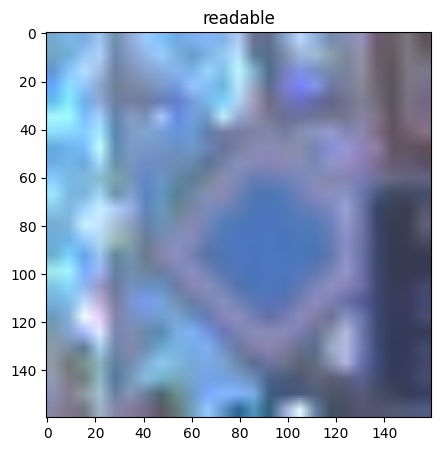

In [ ]:
plt.figure(figsize = (5,5))
plt.imshow(img_data[1][0])
plt.title(labels[img_data[0][1]])

Text(0.5, 1.0, 'unreadable')

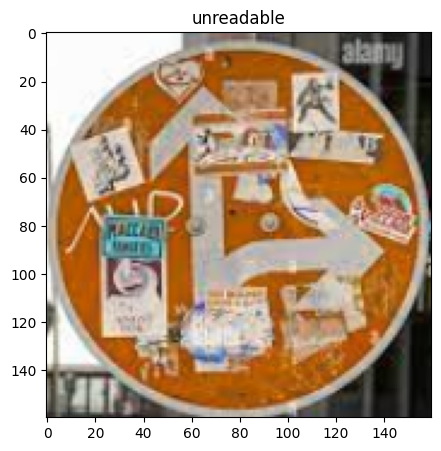

In [ ]:
plt.figure(figsize = (5,5))
plt.imshow(img_data[-1][0])
plt.title(labels[img_data[-1][1]])

In [ ]:
X = []
y = []

for feature, label in img_data:
    X.append(feature)
    y.append(label)

X, y = shuffle(X, y)
X=np.array(X)
y=np.array(y)
X.shape, y.shape


((368, 160, 160, 3), (368,))

In [ ]:
train_size= int(len(X) *0.80)

X_train= X[:train_size]
y_train= y[:train_size]

X_val= X[train_size:]
y_val= y[train_size:]

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((294, 160, 160, 3), (294,), (74, 160, 160, 3), (74,))

In [ ]:
X_train_preproc= preprocess_input(X_train).astype('float')
X_val_preproc= preprocess_input(X_val).astype('float')

y_train= y_train.astype('float')
y_val= y_val.astype('float')

In [ ]:
X_train_preproc.shape, y_train.shape, X_val_preproc.shape, y_val.shape

((294, 160, 160, 3), (294,), (74, 160, 160, 3), (74,))

In [ ]:
def vgg_base_model():
  augmentation = Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomZoom(0.1),
        layers.RandomTranslation(0.2, 0.2),
        layers.RandomRotation(0.1)
    ])
  base_model= VGG16(weights='imagenet', input_shape=X_train[0,:,:].shape, include_top=False)
  base_model.trainable=False

  augment_model = Sequential([
        layers.Input(shape = X_train[0,:,:].shape),
        augmentation,
        base_model,
        layers.Flatten(),
        layers.Dense(1024, activation="relu"),
        layers.Dense(512, activation="relu"),
        layers.Dense(10, activation="relu"),
        layers.Dense(1, activation='sigmoid')
    ])

  augment_model.compile(loss='binary_crossentropy',
                optimizer = Adam(learning_rate= 1e-4),
                metrics=['accuracy'])

  return augment_model

In [ ]:
model= vgg_base_model()

58889256/58889256 [==============================] - 3s 0us/step


In [ ]:
def data_augment(X_train_preproc, y_train, batch_size):
  def custom_augmentation(np_tensor):

    def random_contrast(np_tensor):
        return tf.image.random_contrast(np_tensor, 0.3, 1.2)

    def random_saturation(np_tensor):
        return tf.image.random_saturation(np_tensor, 0.3, 1.2)

    def random_hue(np_tensor):
        return tf.image.random_hue(np_tensor, 0.2)

    def gaussian_noise(np_tensor):
        mean = 0
        # variance: randomly between 1 to 25
        var = np.random.randint(1, 26)
        # sigma is square root of the variance value
        noise = np.random.normal(mean,var**0.5,np_tensor.shape)
        return np.clip(np_tensor + noise, 0, 255).astype('float')

    augmnted_tensor = random_contrast(np_tensor)
    augmnted_tensor = random_saturation(augmnted_tensor)
    augmnted_tensor = random_hue(augmnted_tensor)
    augmnted_tensor = gaussian_noise(augmnted_tensor)
    return np.array(augmnted_tensor)

  train_datagen = ImageDataGenerator(featurewise_center = False,
    featurewise_std_normalization = False,
    rotation_range = 10,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True, shear_range=0.1,
    zoom_range = (0.8, 1.2), brightness_range=(0.8,1.2), preprocessing_function= custom_augmentation)

  train_datagen.fit(X_train_preproc)

  train_flow = train_datagen.flow(X_train_preproc, y_train, batch_size = batch_size)
  return train_flow

In [ ]:
train_flow= data_augment(X_train_preproc, y_train, 32)

In [ ]:
def train_augment(model, train_flow, batch_size, patience):
  es= EarlyStopping(monitor='val_accuracy', mode='max', restore_best_weights=True, patience=patience)

  history = model.fit(train_flow,
                          batch_size=batch_size,
                          epochs = 50,
                          callbacks = [es],
                          validation_data = (X_val_preproc, y_val))

  return model, history

In [ ]:
aug_model= vgg_base_model()
model, history= train_augment(aug_model, train_flow, 32, 5)

Epoch 1/50
10/10 [==============================] - 134s 13s/step - loss: 1.0515 - accuracy: 0.4864 - val_loss: 0.6899 - val_accuracy: 0.6486
Epoch 2/50
10/10 [==============================] - 141s 15s/step - loss: 0.6467 - accuracy: 0.6020 - val_loss: 0.5632 - val_accuracy: 0.7297
Epoch 3/50
10/10 [==============================] - 143s 15s/step - loss: 0.5292 - accuracy: 0.7517 - val_loss: 0.4844 - val_accuracy: 0.7838
Epoch 4/50
10/10 [==============================] - 142s 15s/step - loss: 0.4122 - accuracy: 0.8265 - val_loss: 0.5461 - val_accuracy: 0.8919
Epoch 5/50
10/10 [==============================] - 145s 15s/step - loss: 0.3390 - accuracy: 0.8878 - val_loss: 0.7267 - val_accuracy: 0.8649
Epoch 6/50
10/10 [==============================] - 124s 13s/step - loss: 0.3263 - accuracy: 0.9014 - val_loss: 0.7446 - val_accuracy: 0.8649
Epoch 7/50
10/10 [==============================] - 143s 15s/step - loss: 0.2773 - accuracy: 0.8844 - val_loss: 0.9417 - val_accuracy: 0.8919
Epoch 

## Visualize the History & Evaluate

In [ ]:
def plot_history(history, title=''):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(history.history['loss'], label = 'train_loss')
    ax1.plot(history.history['val_loss'], label = 'val_loss')
    ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy')
    ax2.plot(history.history['val_accuracy'], label='val accuracy')
    ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

(<Axes: title={'center': 'loss'}>, <Axes: title={'center': 'Accuracy'}>)

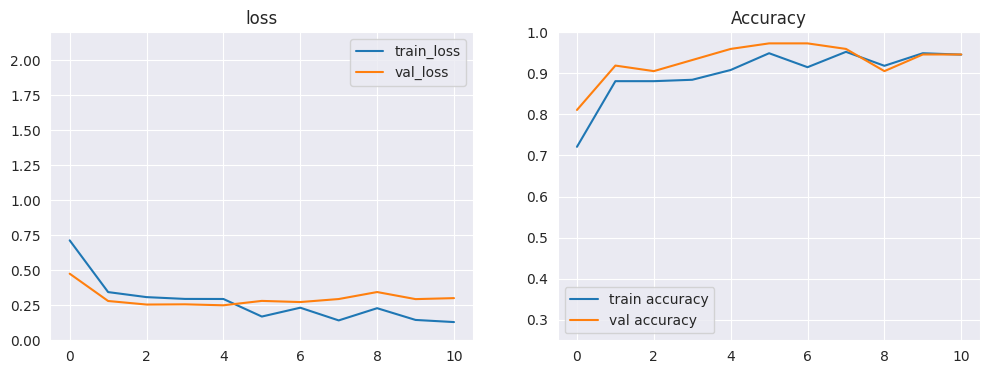

In [ ]:
plot_history(history)

In [ ]:
def model_evaluate(model, X, y):
  score= model.evaluate(X, y)[1]
  return f'Test score= {score:.2f}'

In [ ]:
test_data= create_dataset(img_folder + '/test')

X_test = []
y_test = []

for feature, label in test_data:
    X_test.append(feature)
    y_test.append(label)

X_test, y_test = shuffle(X_test, y_test)
X_test=np.array(X_test)
y_test=np.array(y_test)

X_test_preproc= preprocess_input(X_test).astype('float')
y_test= y_test.astype('float')

X_test_preproc.shape, y_test.shape

<ipython-input-6-8af2a0bb0bb9>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(img_data_array)


((92, 160, 160, 3), (92,))

In [ ]:
model_evaluate(model, X_test_preproc, y_test)

3/3 [==============================] - 32s 11s/step - loss: 0.3900 - accuracy: 0.9457


'Test score= 0.95'

In [ ]:
model_path= '/content/drive/My Drive/Colab_Notebooks/project_traffic_signs/models/improved_model3.h5'
model.save(model_path)

In [ ]:
model_path= '/content/drive/My Drive/Colab_Notebooks/project_traffic_signs/models/improved_model3.h5'
model= tf.keras.models.load_model(model_path)

## **Model_Testing**

In [ ]:
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
y_test= y_test.astype('float')

In [ ]:
#model_path= '/content/drive/My Drive/Colab Notebooks/Matuschkalulu/traffic_signs/models/improved_model.h5'
y_pred= model.predict(X_test_preproc)

3/3 [==============================] - 30s 10s/step


In [ ]:
y_pred= np.round(y_pred)
target_names=['readable', 'unreadable']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    readable       0.96      0.93      0.95        46
  unreadable       0.94      0.96      0.95        46

    accuracy                           0.95        92
   macro avg       0.95      0.95      0.95        92
weighted avg       0.95      0.95      0.95        92



In [ ]:
print(confusion_matrix(y_test, y_pred))

[[43  3]
 [ 2 44]]


## **Model Testing**

In [ ]:
y_pred= np.round(y_pred).astype(int)

In [ ]:
y_test[:10]

array([0., 1., 1., 1., 1., 0., 0., 0., 0., 0.])

In [ ]:
y_pred[0:10].reshape(1,-1)

array([[1, 1, 1, 1, 1, 0, 0, 1, 0, 0]])

In [ ]:
for n in range(5):
  plt.subplot(1,5,n+1)
  plt.imshow(test_data[n][0].astype('float32'))
  #plt.title(labels[y_pred][n].title())
  plt.axis('off')
#_ = plt.suptitle("Model predictions")
  plt.show()

In [ ]:
plt.figure(figsize = (5,5))
plt.imshow(test_data[1][0])
plt.title(labels[test_data[0][1]])

In [ ]:
for f in os.listdir(img_folder + '/test'):
    #image_path= os.path.join(img_folder, dir1,  file)
    image= cv2.imread(os.path.join(img_folder, '/test', f), cv2.COLOR_BGR2RGB)
    print(image.shape)
    image=cv2.resize(image, (160, 160),interpolation = cv2.INTER_AREA)
    image=np.array(image)
    # image = image.astype('float')
    # img_data_array.append(image)
    # class_name.append(dir1)

In [ ]:
y_test.squeeze().shape

(92,)

In [ ]:
import pandas as pd
from sklearn.metrics import mean_squared_error

In [ ]:
result_df= pd.DataFrame({'y_test':y_test.squeeze(), 'y_pred':y_pred.squeeze()})
#result_df.head(20)

In [ ]:
mse= mean_squared_error(y_test, np.round(y_pred).astype(int))
mse

0.05434782608695652

In [ ]:
for f in os.listdir(img_folder + '/test' + '/readable'):
    img = image.load_img(os.path.join(img_folder, 'test', 'readable', f), target_size=(160, 160))
    img_array = image.img_to_array(img)

    img_batch = np.expand_dims(img_array, axis=0)

    img_preprocessed = preprocess_input(img_batch)

    prediction = model.predict(img_preprocessed)
    plt.imshow(img)
    plt.show()
    print(prediction[0])

1/1 [==============================] - 0s 21ms/step


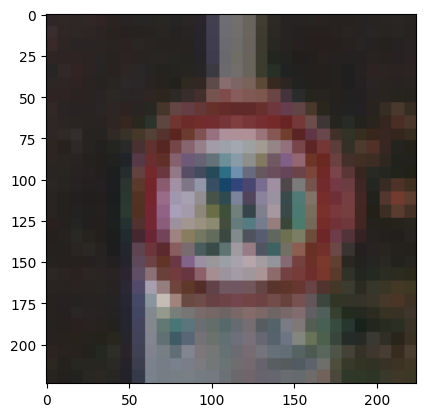

[[0.94005615]]
1/1 [==============================] - 0s 20ms/step


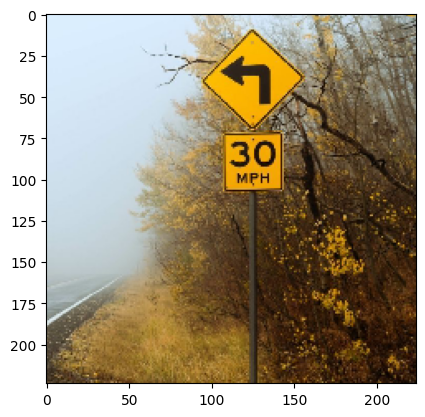

[[0.9999881]]
1/1 [==============================] - 0s 23ms/step


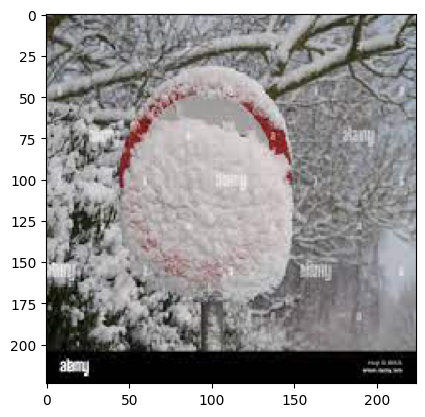

[[1.]]
1/1 [==============================] - 0s 21ms/step


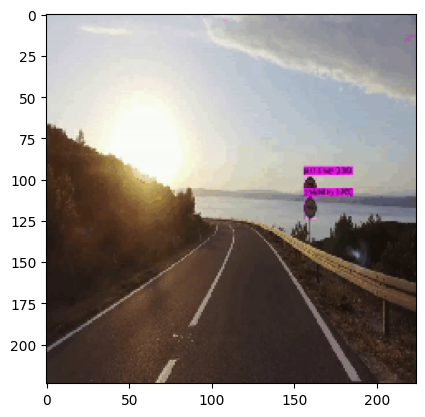

[[0.00094641]]
1/1 [==============================] - 0s 33ms/step


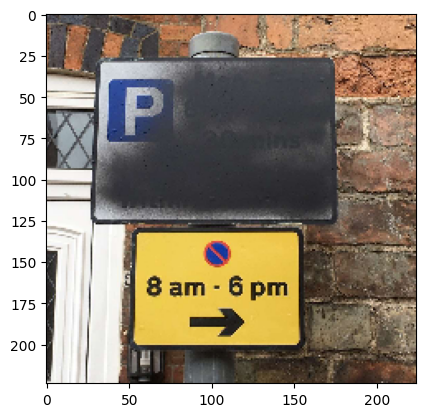

[[1.]]
1/1 [==============================] - 0s 19ms/step


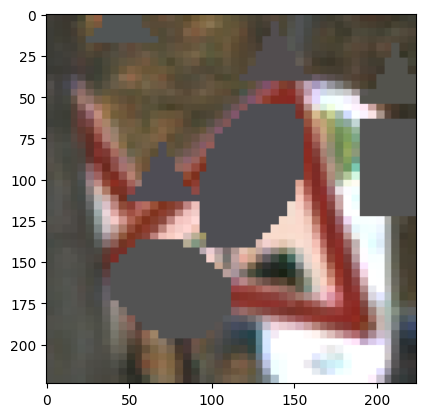

[[0.00021327]]
1/1 [==============================] - 0s 34ms/step


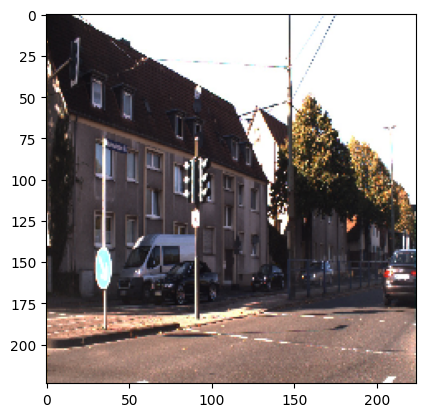

[[0.9997795]]
1/1 [==============================] - 0s 31ms/step


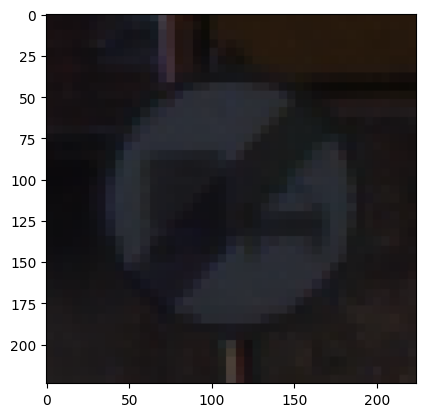

[[0.00959321]]
1/1 [==============================] - 0s 41ms/step


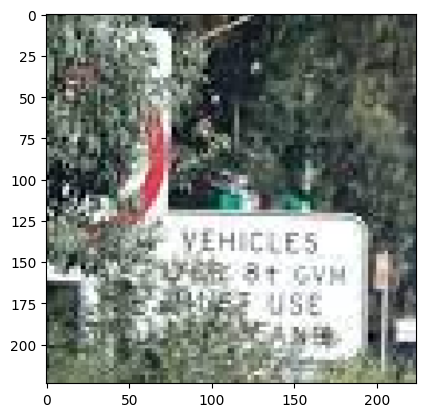

[[0.9999969]]
1/1 [==============================] - 0s 23ms/step


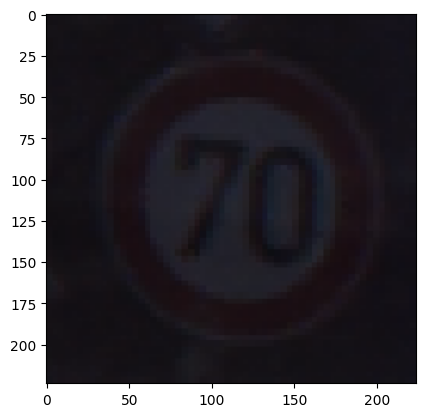

[[5.5943525e-07]]
1/1 [==============================] - 0s 32ms/step


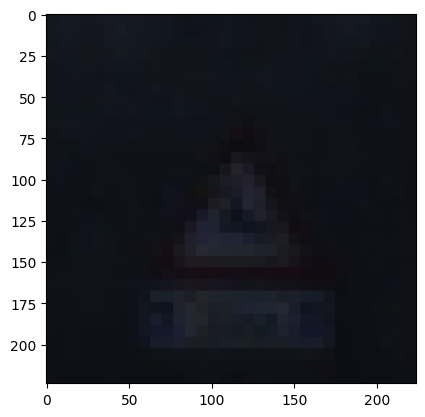

[[0.00560698]]
1/1 [==============================] - 0s 19ms/step


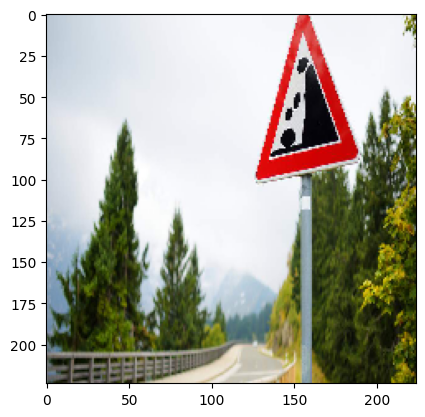

[[0.99963677]]
1/1 [==============================] - 0s 21ms/step


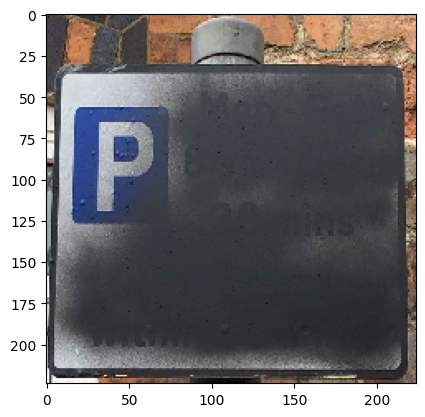

[[1.]]
1/1 [==============================] - 0s 21ms/step


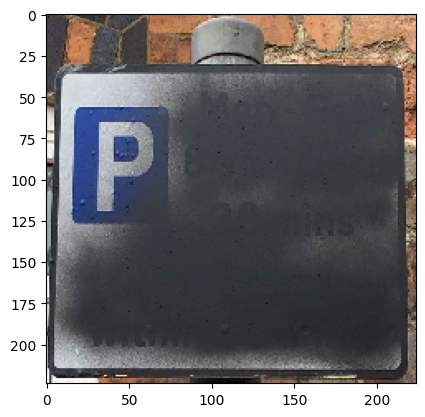

[[1.]]
1/1 [==============================] - 0s 19ms/step


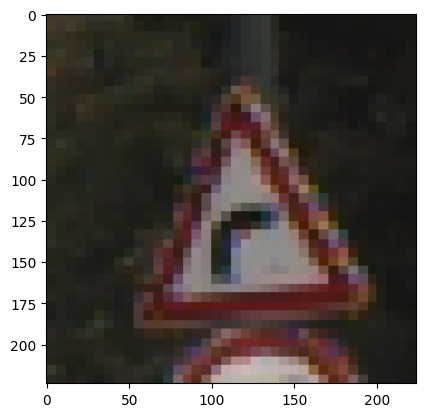

[[0.22388342]]
1/1 [==============================] - 0s 20ms/step


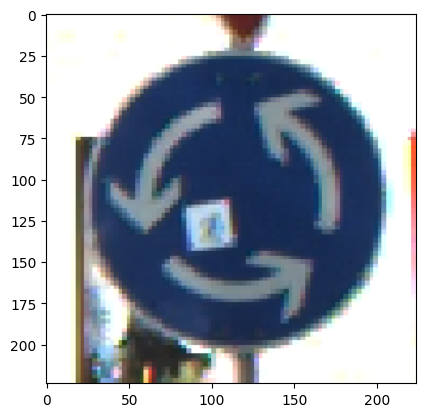

[[3.9377082e-13]]
1/1 [==============================] - 0s 28ms/step


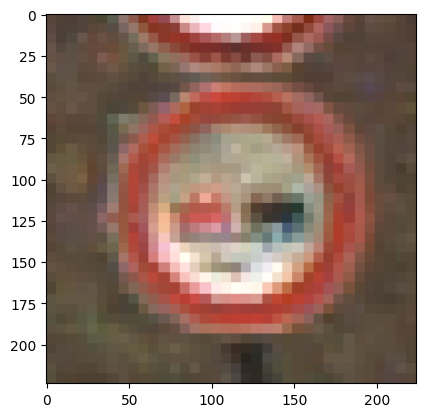

[[0.5738391]]
1/1 [==============================] - 0s 28ms/step


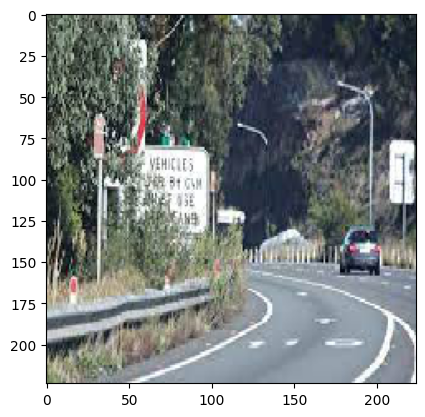

[[0.9377802]]
1/1 [==============================] - 0s 25ms/step


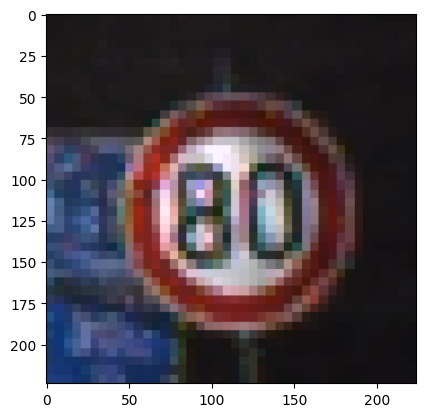

[[0.31275424]]
1/1 [==============================] - 0s 19ms/step


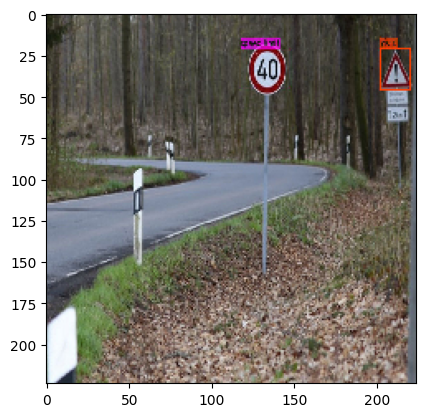

[[0.99982065]]
1/1 [==============================] - 0s 23ms/step


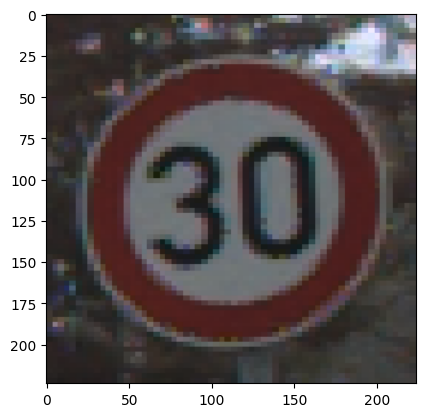

[[0.6490141]]
1/1 [==============================] - 0s 20ms/step


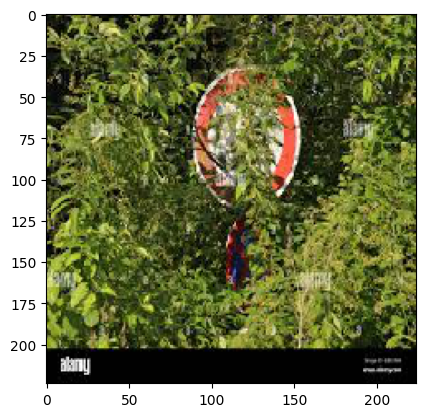

[[0.99999976]]
1/1 [==============================] - 0s 23ms/step


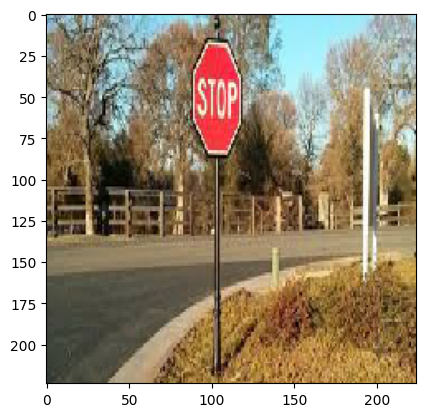

[[0.9999963]]
1/1 [==============================] - 0s 22ms/step


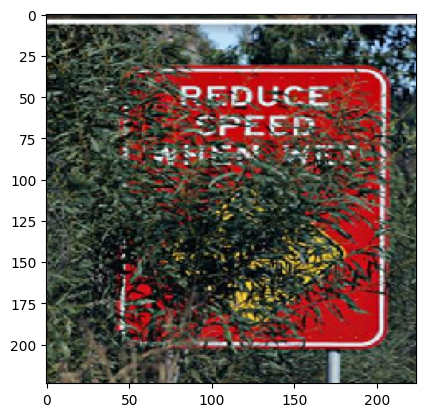

[[1.]]
1/1 [==============================] - 0s 22ms/step


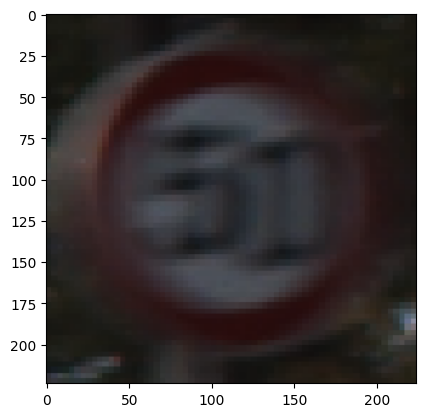

[[1.5100487e-07]]
1/1 [==============================] - 0s 20ms/step


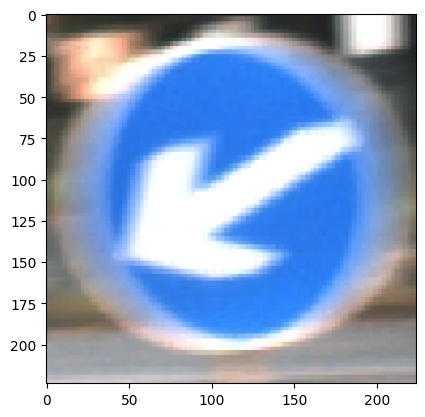

[[4.5320095e-07]]
1/1 [==============================] - 0s 30ms/step


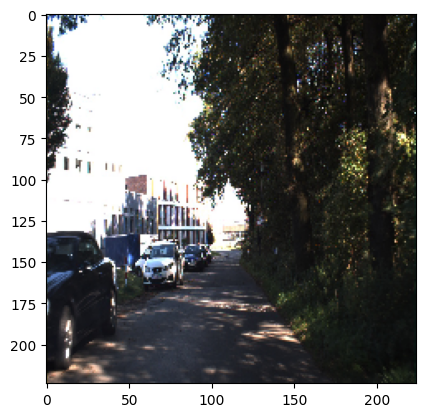

[[0.7508518]]
1/1 [==============================] - 0s 28ms/step


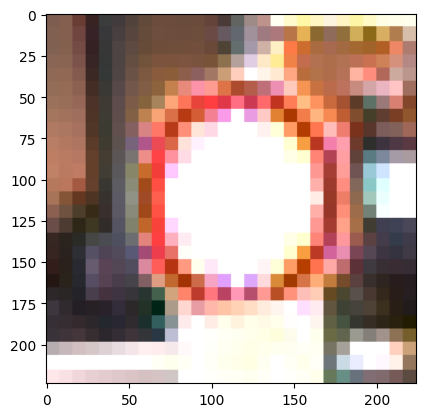

[[0.9999994]]
1/1 [==============================] - 0s 20ms/step


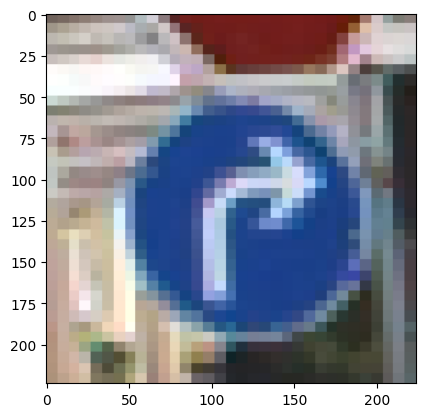

[[0.9999987]]
1/1 [==============================] - 0s 25ms/step


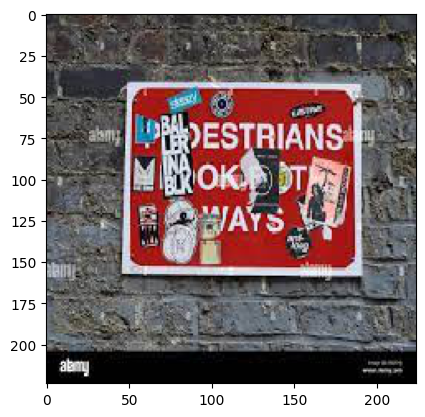

[[1.]]
1/1 [==============================] - 0s 29ms/step


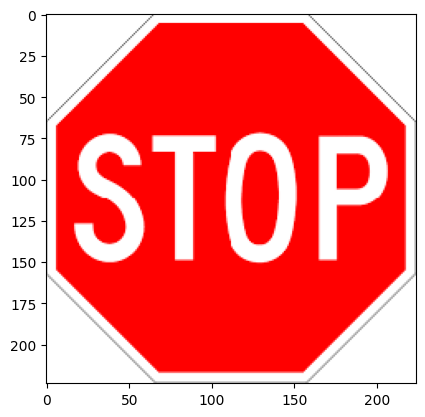

[[1.]]
1/1 [==============================] - 0s 32ms/step


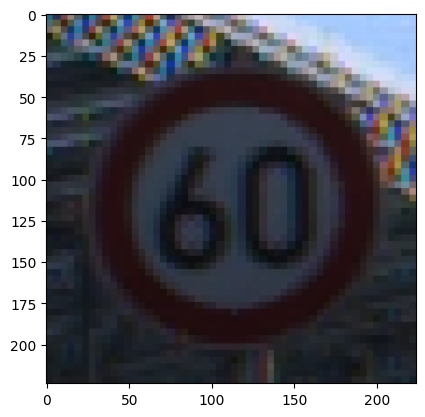

[[0.00643969]]


In [ ]:
test_images= '/content/drive/My Drive/Colab_Notebooks/project_traffic_signs/croped_train_data/test_images/'
for img in os.listdir(test_images):
    img = image.load_img(test_images + img, target_size=(224, 224))
    img_array = image.img_to_array(img)

    img_batch = np.expand_dims(img_array, axis=0)

    img_preprocessed = preprocess_input(img_batch)

    prediction = model.predict(img_preprocessed)
    plt.imshow(img)
    plt.show()
    print(prediction)

1/1 [==============================] - 0s 33ms/step


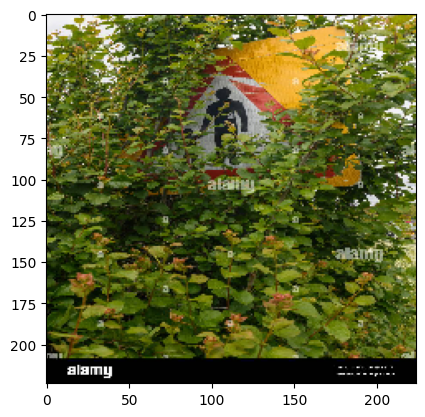

[[0.9999994]]


In [ ]:
test_images= '/content/drive/My Drive/Colab_Notebooks/project_traffic_signs/croped_train_data/test_images/example_new.jpg'
img = image.load_img(test_images, target_size=(224, 224))
img_array = image.img_to_array(img)

img_batch = np.expand_dims(img_array, axis=0)

img_preprocessed = preprocess_input(img_batch)

prediction = model.predict(img_preprocessed)
plt.imshow(img)
plt.show()
print(prediction)

1/1 [==============================] - 0s 90ms/step


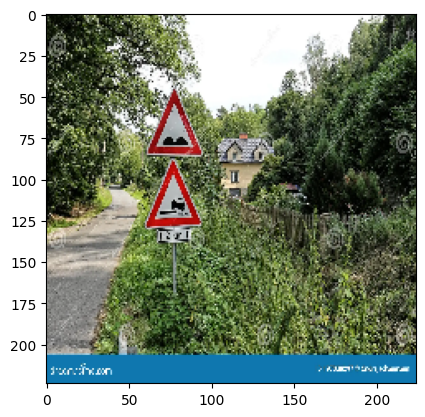

[[1.]]


In [ ]:
test_images= '/content/drive/My Drive/Colab_Notebooks/project_traffic_signs/croped_train_data/test_images/example13.webp'
img = image.load_img(test_images, target_size=(224, 224))
img_array = image.img_to_array(img)

img_batch = np.expand_dims(img_array, axis=0)

img_preprocessed = preprocess_input(img_batch)

prediction = model.predict(img_preprocessed)
plt.imshow(img)
plt.show()
print(prediction)

1/1 [==============================] - 0s 28ms/step


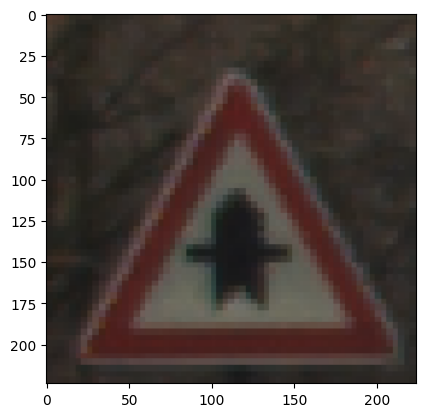

[[1.5572431e-06]]
1/1 [==============================] - 0s 21ms/step


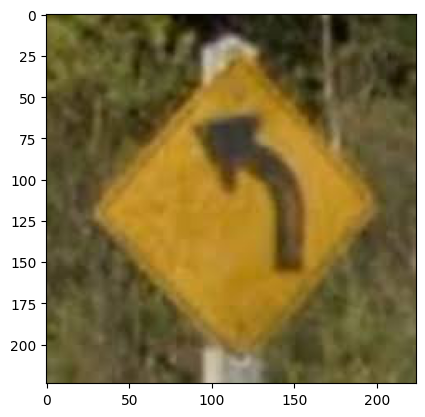

[[0.99998116]]
1/1 [==============================] - 0s 25ms/step


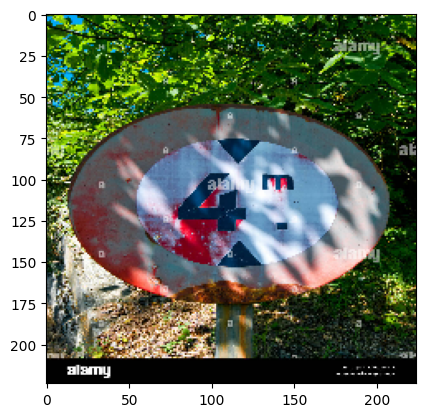

[[1.]]
1/1 [==============================] - 0s 19ms/step


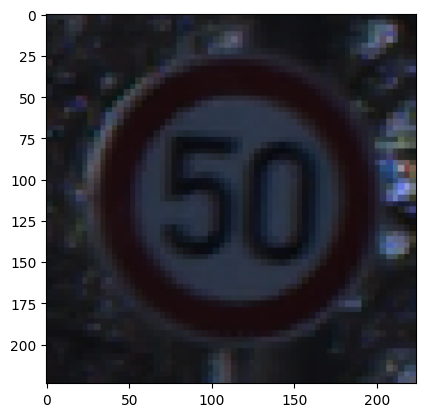

[[5.8613277e-05]]
1/1 [==============================] - 0s 34ms/step


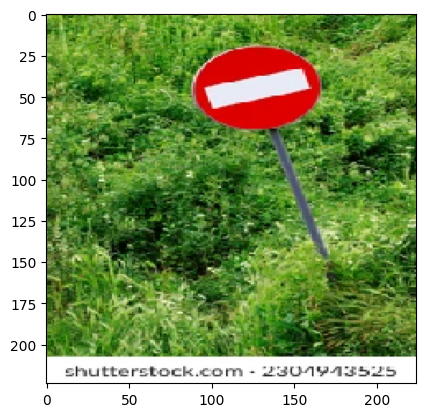

[[0.99929965]]
1/1 [==============================] - 0s 34ms/step


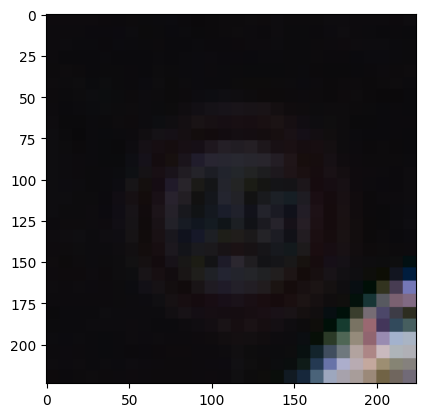

[[0.00015232]]
1/1 [==============================] - 0s 19ms/step


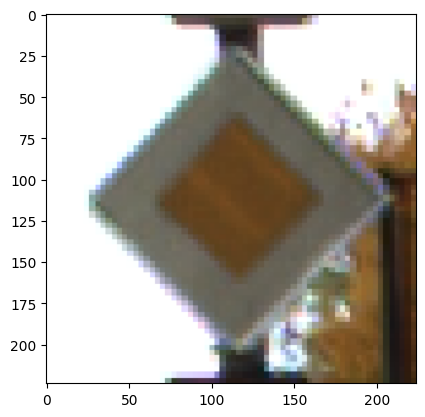

[[4.3396892e-10]]
1/1 [==============================] - 0s 20ms/step


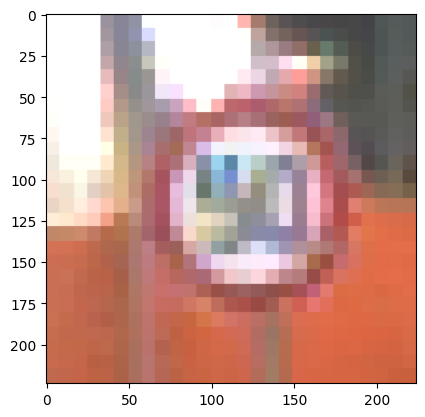

[[0.99997485]]
1/1 [==============================] - 0s 21ms/step


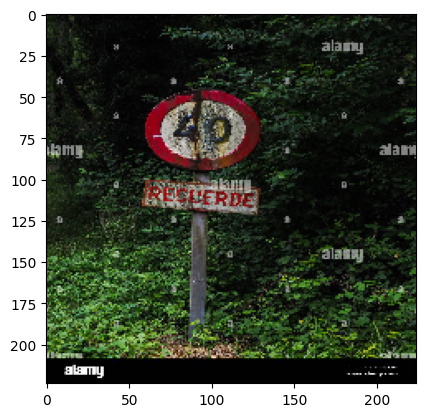

[[1.]]
1/1 [==============================] - 0s 27ms/step


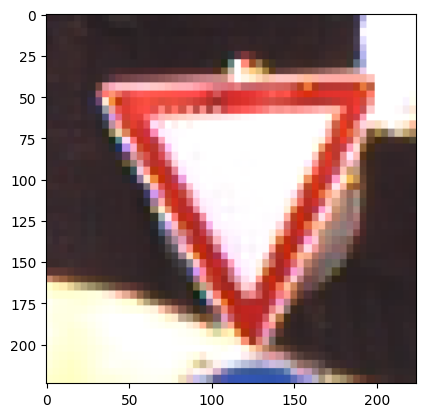

[[0.0009097]]
1/1 [==============================] - 0s 20ms/step


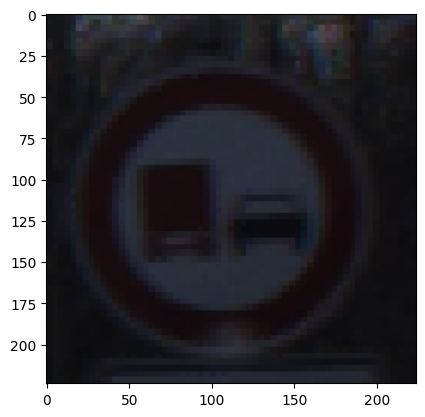

[[9.1049675e-05]]
1/1 [==============================] - 0s 25ms/step


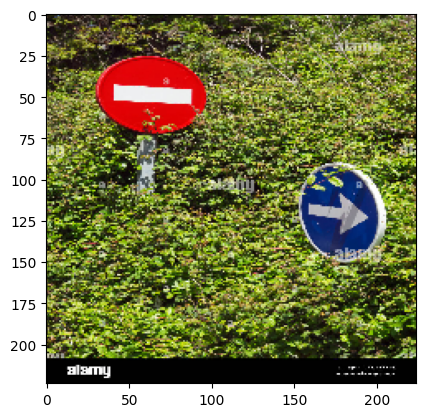

[[0.999992]]
1/1 [==============================] - 0s 19ms/step


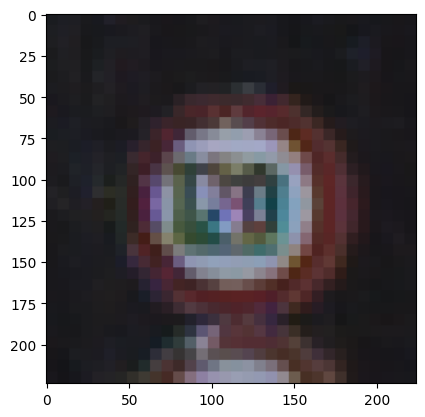

[[0.04141951]]
1/1 [==============================] - 0s 27ms/step


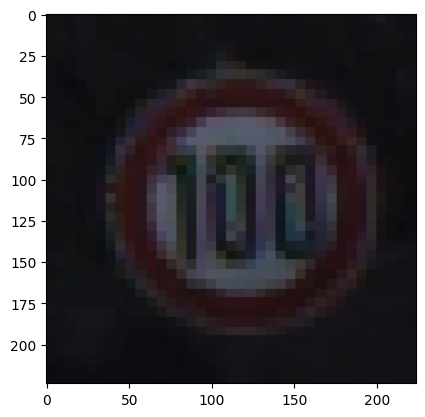

[[0.00040649]]
1/1 [==============================] - 0s 19ms/step


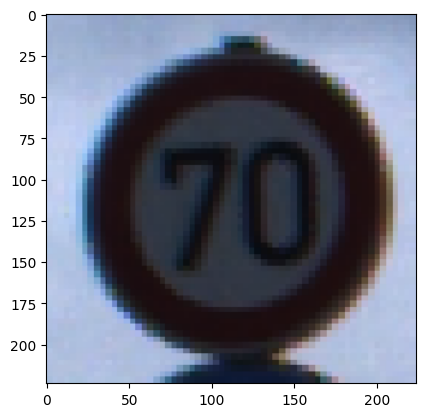

[[2.6698779e-06]]
1/1 [==============================] - 0s 19ms/step


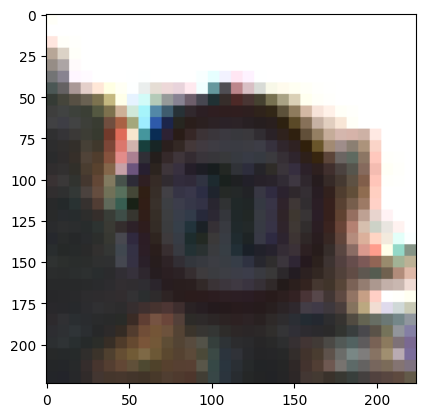

[[0.22282176]]


In [ ]:
test_images= '/content/drive/My Drive/Colab_Notebooks/project_traffic_signs/croped_train_data/test2/'
for img in os.listdir(test_images):
    img = image.load_img(test_images + img, target_size=(224, 224))
    img_array = image.img_to_array(img)

    img_batch = np.expand_dims(img_array, axis=0)

    img_preprocessed = preprocess_input(img_batch)

    prediction = model.predict(img_preprocessed)
    plt.imshow(img)
    plt.show()
    print(prediction)